In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error 
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

from IPython.core.debugger import set_trace

import random

# import xgboost
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

import os

from tqdm import *

import sys
sys.path.insert(0, '../')

np.random.seed(1017)
random.seed(1017)

import scipy.sparse as sp
# tells which GPU to use.

import torch
from torch.utils.data import Dataset, DataLoader

from egexplainer import AttributionPriorExplainer
torch.set_num_threads(1)

In [2]:
def gsea_gmt_parser(gmt, min_size = 3, max_size = 1000, gene_list=None):
    import logging
    """Parse gene_sets.gmt(gene set database) file or download from enrichr server.
    :param gmt: the gene_sets.gmt file of GSEA input 
    :return: Return a new filtered gene set database dictionary.
    **DO NOT** filter gene sets, when use :func:`replot`. Because ``GSEA`` Desktop have already
    done this for you.
    """

    if gmt.lower().endswith(".gmt"):
        logging.info("User Defined gene sets is given.......continue..........")
        with open(gmt) as genesets:
             genesets_dict = { line.strip().split("\t")[0]: line.strip().split("\t")[2:]
                              for line in genesets.readlines()}
    else:
        print('bruh')
        
    # filtering dict
    if sys.version_info[0] >= 3 :
        genesets_filter =  {k: v for k, v in genesets_dict.items() if len(v) >= min_size and len(v) <= max_size}
    elif sys.version_info[0] == 2:
        genesets_filter =  {k: v for k, v in genesets_dict.iteritems() if len(v) >= min_size and len(v) <= max_size}
    else:
        logging.error("System failure. Please Provide correct input files")
        sys.exit(1)
    if gene_list is not None:
        subsets = sorted(genesets_filter.keys())
        for subset in subsets:
            tag_indicator = in1d(gene_list, genesets_filter.get(subset), assume_unique=True)
            tag_len = sum(tag_indicator)
            if tag_len <= min_size or tag_len >= max_size:
                del genesets_filter[subset]
            else:
                continue
    # some_dict = {key: value for key, value in some_dict.items() if value != value_to_remove}
    # use np.intersect1d() may be faster???
    filsets_num = len(genesets_dict) - len(genesets_filter)
    logging.info("%04d gene_sets have been filtered out when max_size=%s and min_size=%s"%(filsets_num, max_size, min_size))

    if filsets_num == len(genesets_dict):
        logging.error("No gene sets passed throught filtering condition!!!, try new paramters again!\n" +\
                         "Note: Gene names for gseapy is case sensitive." )
        sys.exit(1)
    else:
        return genesets_filter

In [3]:
c2_dict = gsea_gmt_parser('./c2.all.v7.0.symbols.gmt')

In [4]:
kbr_pathways = []

#for x in c2_dict.keys():
#    if 'REACTOME' in x or 'KEGG' in x or 'BIOCARTA' in x:
#        kbr_pathways.append(x)

for x in c2_dict.keys():
    if 'KEGG' in x:
        kbr_pathways.append(x)

# pre-process abeta data

In [5]:
data_dir = "/projects/leelab2/jjanizek/"

##
## put everything in 0-1 by region
##

#Read all region expressions
regions = ['ACT_FWM', 'ACT_HIP', 'ACT_PCx', 'ACT_TCx', 'MSBB_BM10', 'MSBB_BM22', 'MSBB_BM36', 'MSBB_BM44', 'ROSMAP' ]

data_list = []

for region in regions:
    
    #Read expression
    data_df = pd.read_table(data_dir + 'AD_DATA/abeta_' + region + '.csv', index_col = 0, sep = ',')
    
    data_df.columns = ['abeta']
    
    standardized_df = (data_df - data_df.min())/(data_df.max()- data_df.min())

    #Append to list
    data_list.append(standardized_df)
    
    #Join all data
joined_df = pd.concat(data_list, axis = 0)

In [6]:
y = joined_df

In [7]:
X = pd.read_csv(data_dir + 'AD_DATA/AD_DATA/AD_RnaSeq_Expression_Standardized_Batch_Corrected.tsv',sep='\t',index_col=0)

/homes/gws/ewein/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
X.columns

Index(['C2orf76', 'ACTL10', 'CEP135', 'MIIP', 'CCDC86', 'TRIM6', 'NKD1',
       'GNL3', 'ERICH6', 'TM9SF1',
       ...
       'EBI3', 'ICA1', 'GPC6', 'USP49', 'DNAL4', 'PPM1F', 'CCDC94', 'CLN6',
       'ITIH2', 'ABCA8'],
      dtype='object', length=14912)

In [9]:
A = np.zeros((X.shape[1],len(kbr_pathways)))

In [10]:
for i,x in tqdm(enumerate(list(X))):
    for j,path in enumerate(kbr_pathways):
        if x in c2_dict[path]:
            A[i,j] = 1

14912it [00:03, 4035.12it/s]


In [11]:
#rowsums = A.sum(1)
#rowsums[rowsums == 0] = 1
#rowsums = rowsums.reshape(-1,1)
#A_norm = A/rowsums

genes_with_pathways = (A.sum(axis=1) != 0)
X = X.T[genes_with_pathways].T
#A_norm = A_norm[genes_with_pathways]
A = A[genes_with_pathways]

In [12]:
A.shape

(4027, 186)

In [13]:
#Split the data to training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1017)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=1017)

In [14]:
feature_scaler = StandardScaler()
outcome_scaler = StandardScaler()

y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

feature_scaler.fit(X_train)
outcome_scaler.fit(y_train)

X_train_ss,X_test_ss = feature_scaler.transform(X_train),feature_scaler.transform(X_test)
y_train_ss,y_test_ss = outcome_scaler.transform(y_train),outcome_scaler.transform(y_test)

In [15]:
feature_scaler = StandardScaler()
outcome_scaler = StandardScaler()

y_tr = y_tr.values.reshape(-1, 1)
y_val = y_val.values.reshape(-1, 1)

feature_scaler.fit(X_tr)
outcome_scaler.fit(y_tr)

X_tr_ss,X_val_ss = feature_scaler.transform(X_tr),feature_scaler.transform(X_val)
y_tr_ss,y_val_ss = outcome_scaler.transform(y_tr),outcome_scaler.transform(y_val)

In [16]:
class ADData(Dataset):
    
    def __init__(self, X, y=None, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        sample = self.X[index,:]
        
        if self.transform is not None:
            sample = self.transform(sample)
            
        if self.y is not None:
            return sample, self.y[index]
        else:
            return sample

In [17]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N = 32

# Create random Tensors to hold inputs and outputs
train_dataset = ADData(X_train_ss,y_train_ss)
test_dataset = ADData(X_test_ss,y_test_ss)

train_loader = DataLoader(dataset=train_dataset, batch_size=N, shuffle=True,drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=test_dataset.X.shape[0], shuffle=False,drop_last=False)

In [137]:
learning_rate = 1e-4
prior_learning_rate = 1e-5

num_epochs = 50

In [89]:
from models import MLP

D_in, H1, H2, D_out = X_train.shape[1], 512, 256, 1
f1 = MLP(D_in=D_in, H1=H1, H2=H2, D_out=D_out, dropout=0.2).cuda().float()
f1_optimizer = torch.optim.Adam(f1.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

mlp_errors = []

def train(model, num_epochs):
    
    print("Beginning model training at {}".format(datetime.datetime.now()))
    test_losses = []
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        for X_batch, y_batch in train_loader:
            f1_optimizer.zero_grad()
            X_batch = X_batch.float().cuda()
            y_batch = y_batch.float().cuda()
            
            output = model(X_batch)
            loss_train = criterion(output, y_batch)
            
            loss_train.backward()
            f1_optimizer.step()
            
        model.eval()
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.float().cuda()
            y_batch = y_batch.float().cuda()

            output = model(X_batch)
            loss_test = criterion(output, y_batch).item()
            end_time = time.time()
            epoch_time = end_time - start_time
            test_losses.append(loss_test)
        
        if epoch % 10 == 0:
            print("Epoch {} completed in {} secs with test loss {:.4f}".format(epoch, epoch_time, loss_test))
    mlp_errors.append(test_losses)

In [90]:
import datetime
import time
import logging

logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

train(f1, num_epochs)

Beginning model training at 2019-11-26 11:09:47.940490
Epoch 0 completed in 0.23772478103637695 secs with test loss 1.0570
Epoch 10 completed in 0.22548890113830566 secs with test loss 1.0083
Epoch 20 completed in 0.22560429573059082 secs with test loss 0.9906
Epoch 30 completed in 0.22519707679748535 secs with test loss 0.9818
Epoch 40 completed in 0.22853803634643555 secs with test loss 0.9754
Epoch 50 completed in 0.22767090797424316 secs with test loss 0.9696
Epoch 60 completed in 0.22405123710632324 secs with test loss 0.9644
Epoch 70 completed in 0.226531982421875 secs with test loss 0.9594
Epoch 80 completed in 0.22808408737182617 secs with test loss 0.9546
Epoch 90 completed in 0.22284269332885742 secs with test loss 0.9499
Epoch 100 completed in 0.22797632217407227 secs with test loss 0.9452
Epoch 110 completed in 0.22402310371398926 secs with test loss 0.9407
Epoch 120 completed in 0.22800207138061523 secs with test loss 0.9360
Epoch 130 completed in 0.22645187377929688 secs 

In [91]:
import egexplainer
import importlib

importlib.reload(egexplainer)

APExp = egexplainer.VariableBatchExplainer(train_dataset)

In [92]:
prior_info = torch.FloatTensor(A).cuda()

In [138]:
prior_mlp_errors = []

def train_with_learned_prior(f1, f2, num_epochs, prior_lambda):
    
    print("Beginning model training at {}".format(datetime.datetime.now()))
    
    test_losses = []
    for epoch in range(num_epochs):
        start_time = time.time()
        f1.train()
        for X_batch, y_batch in train_loader:
            f1_optimizer.zero_grad()
            f2_optimizer.zero_grad()
            
            X_batch = X_batch.float().cuda()
            y_batch = y_batch.float().cuda()
            
            output = f1(X_batch)
            
            eg = APExp.shap_values(f1, X_batch)
            prior_differences = f2(prior_info).squeeze()
            prior_loss = (prior_differences - eg).abs().mean()
            
            loss_train = criterion(output, y_batch) + prior_lambda*prior_loss
            
            loss_train.backward()
            f1_optimizer.step()
            f2_optimizer.step()
            
        f1.eval()
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.float().cuda()
            y_batch = y_batch.float().cuda()

            output = f1(X_batch)
            loss_test = criterion(output, y_batch).item()
            end_time = time.time()
            epoch_time = end_time - start_time
            test_losses.append(loss_test)
        
        if epoch % 10 == 0:
            print("Epoch {} completed in {} secs with test loss {:.4f}".format(epoch, epoch_time, loss_test))
    print("Using lambda {} achieved final error of {}".format(prior_lambda, loss_test))
    prior_mlp_errors.append(test_losses)

In [157]:
from models import LinearModel

D_in, H1, H2, D_out = X_train.shape[1], 512, 256, 1

#for prior_lambda in np.linspace(1, 150, num=20):
f1 = MLP(D_in=D_in, H1=H1, H2=H2, D_out=D_out, dropout=0.2).cuda().float()
f1_optimizer = torch.optim.Adam(f1.parameters(), lr=learning_rate)

"""
f2 = MLP(
    D_in = prior_info.shape[1],
    H1 = 512,
    H2 = 216,
    D_out = 1,
    dropout = 0.2
).cuda().float()
"""
f2 = LinearModel(
    D_in = prior_info.shape[1],
    D_out = 1
).cuda()
f2_optimizer = torch.optim.Adam(f2.parameters(), lr=prior_learning_rate)
train_with_learned_prior(f1, f2, num_epochs, prior_lambda=1)

Beginning model training at 2019-11-26 11:37:39.838245
Epoch 0 completed in 0.5442447662353516 secs with test loss 1.0585
Epoch 10 completed in 0.5328037738800049 secs with test loss 0.7777
Epoch 20 completed in 0.5276718139648438 secs with test loss 0.7409
Epoch 30 completed in 0.5305657386779785 secs with test loss 0.7244
Epoch 40 completed in 0.522951602935791 secs with test loss 0.7485
Using lambda 1 achieved final error of 0.7519419193267822


In [158]:
from data import BasicDataset

prior_data = BasicDataset(X = prior_info, y = np.zeros(prior_info.shape[0]))

meta_APExp = egexplainer.VariableBatchExplainer(prior_data)

In [159]:
for X_batch, y_batch in test_loader:
    y_batch = y_batch.squeeze()
    X_batch = X_batch.float().cuda()
    y_batch = y_batch.float().cuda()
    predicted_attributions = f2(prior_info).abs().squeeze().cpu().detach().numpy()
    meta_eg = meta_APExp.shap_values(f2, prior_info).abs().cpu().detach().numpy()

In [160]:
meta_eg = np.abs(meta_eg)
row_sums = meta_eg.sum(axis=1)
meta_eg = meta_eg / row_sums[:, np.newaxis]
meta_eg = (meta_eg.T * predicted_attributions).T

/homes/gws/ewein/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [161]:
df = pd.DataFrame(meta_eg, columns=kbr_pathways, index=X.columns)
df["total_attribution"]= predicted_attributions

In [162]:
num_bars = 25
data_to_plot = df.dropna().nlargest(num_bars, "total_attribution")
data_to_plot = data_to_plot.sort_values(by="total_attribution", ascending=True)

Text(0.5, 0, 'Predicted Attribution Val')

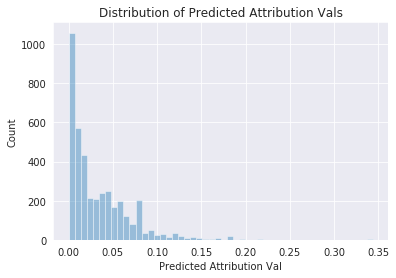

In [163]:
import seaborn as sns

sns.set_style("darkgrid")
sns.distplot(df["total_attribution"], kde=False)
plt.title("Distribution of Predicted Attribution Vals")
plt.ylabel("Count")
plt.xlabel("Predicted Attribution Val")

Text(0.5, 1.0, 'Predicted Gene Importance Values')

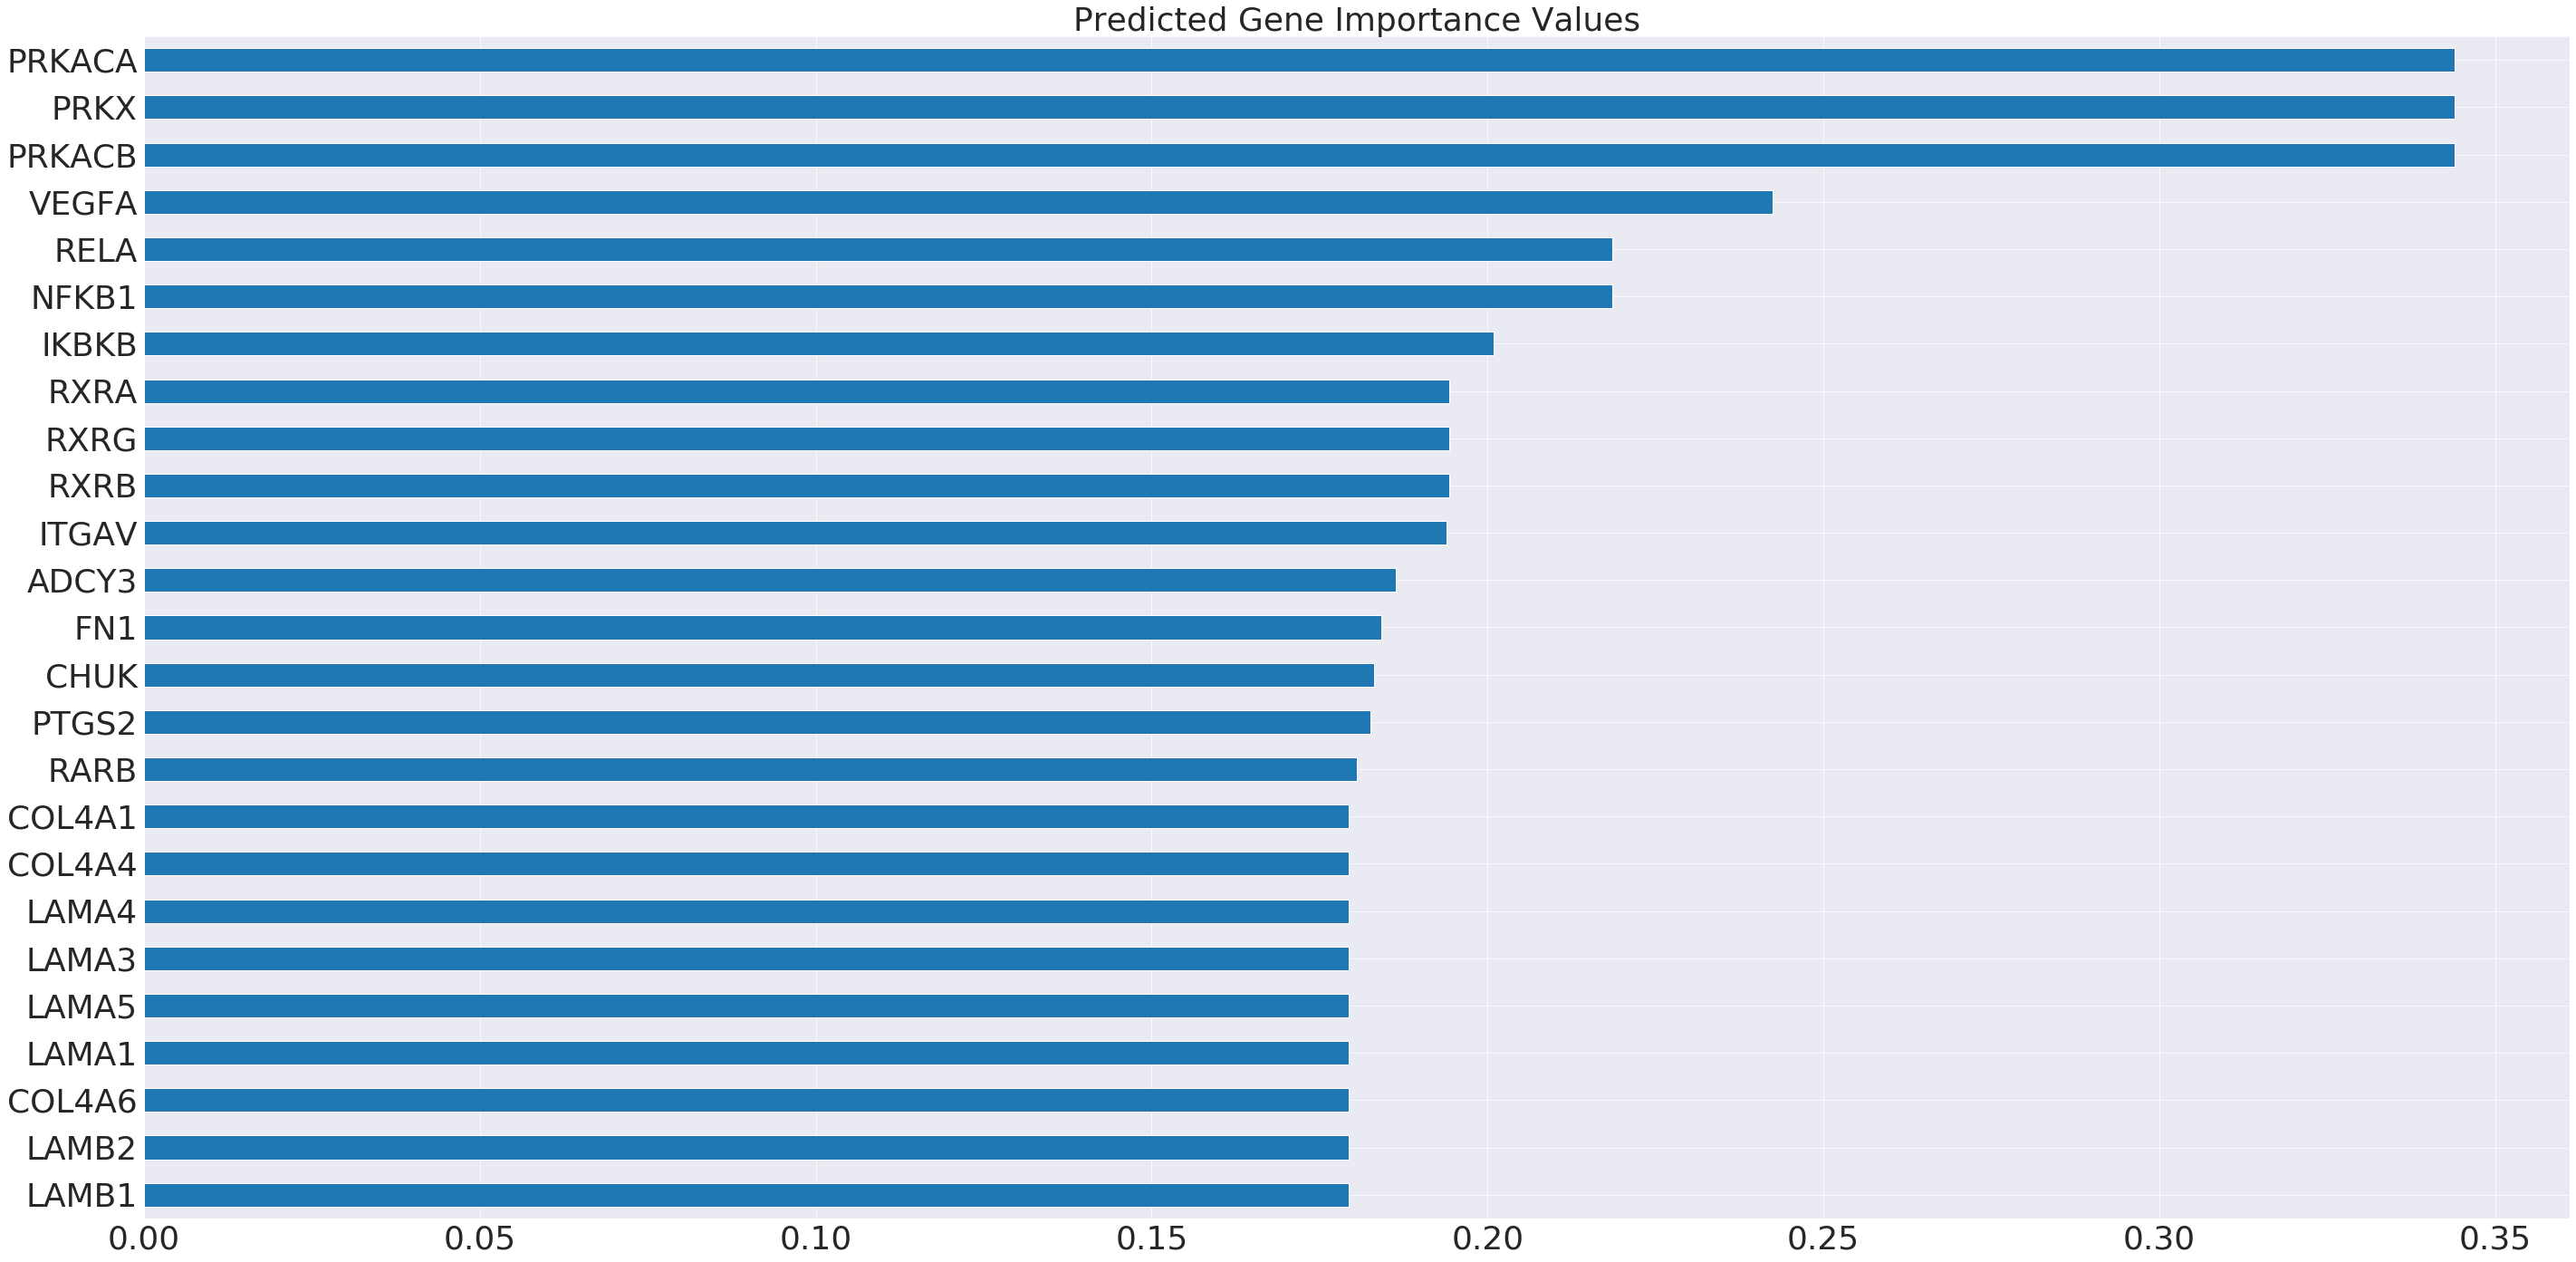

In [164]:
data_to_plot["total_attribution"].plot(
    kind="barh",
    figsize=(48,24)
)
    
plt.xticks(fontsize=36)
plt.yticks(fontsize=36)
plt.title("Predicted Gene Importance Values", fontsize=36)

In [156]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199



display(data_to_plot.sum(axis=0).sort_values(ascending=False))

total_attribution                                                  3.769625
KEGG_INSULIN_SIGNALING_PATHWAY                                     0.242886
KEGG_CHRONIC_MYELOID_LEUKEMIA                                      0.207911
KEGG_PYRUVATE_METABOLISM                                           0.166123
KEGG_TOLL_LIKE_RECEPTOR_SIGNALING_PATHWAY                          0.140349
KEGG_GLYCOLYSIS_GLUCONEOGENESIS                                    0.115536
KEGG_LONG_TERM_POTENTIATION                                        0.111413
KEGG_PHOSPHATIDYLINOSITOL_SIGNALING_SYSTEM                         0.109234
KEGG_EPITHELIAL_CELL_SIGNALING_IN_HELICOBACTER_PYLORI_INFECTION    0.105446
KEGG_FC_GAMMA_R_MEDIATED_PHAGOCYTOSIS                              0.098343
KEGG_GNRH_SIGNALING_PATHWAY                                        0.095276
KEGG_HUNTINGTONS_DISEASE                                           0.089445
KEGG_NEUROTROPHIN_SIGNALING_PATHWAY                                0.086447
KEGG_LEISHMA